In [1]:
# Modisco
%matplotlib inline

import modisco
import json
import os.path
import pandas as pd
from metrics import Pearson
from collections import OrderedDict, Counter, defaultdict
from deeplift.dinuc_shuffle import dinuc_shuffle
import random
from random import shuffle
from keras.models import load_model, model_from_json
from keras.utils import to_categorical
from utils import prepare_data
from importlib import reload
from deeplift.visualization import viz_sequence
import shap
import shap.explainers.deep.deep_tf
reload(shap.explainers.deep.deep_tf)
reload(shap.explainers.deep)
reload(shap.explainers)
reload(shap)
import numpy as np

np.random.seed(1)

In [2]:
#compile the dinucleotide edges
def prepare_edges(s):
 edges = defaultdict(list)
 for i in range(len(s)-1):
     edges[s[i]].append(s[i+1])
 return edges


def shuffle_edges(edges):
 #for each character, remove the last edge, shuffle, add edge back
 for char in edges:
     last_edge = edges[char][-1]
     edges[char] = edges[char][:-1]
     the_list = edges[char]
     shuffle(the_list)
     edges[char].append(last_edge)
 return edges


def traverse_edges(s, edges):
 generated = [s[0]]
 edges_queue_pointers = defaultdict(lambda: 0)
 for i in range(len(s)-1):
     last_char = generated[-1]
     generated.append(edges[last_char][edges_queue_pointers[last_char]])
     edges_queue_pointers[last_char] += 1
 return "".join(generated)

def one_hot_emb(data: pd.DataFrame) -> pd.DataFrame:
    mapping = {
        'A': 0,
        'C': 1,
        'G': 2,
        'T': 3
    }
    one_hot_encode_lam = lambda seq: to_categorical([mapping[x] for x in seq])
    return data.apply(one_hot_encode_lam)

def onehot_dinuc_shuffle(s):
    s = np.squeeze(s)
    argmax_vals = "".join([str(x) for x in np.argmax(s, axis=-1)])
    shuffled_argmax_vals = [int(x) for x in traverse_edges(argmax_vals,
                            shuffle_edges(prepare_edges(argmax_vals)))]
    to_return = np.zeros_like(s)
    to_return[list(range(len(s))), shuffled_argmax_vals] = 1
    return to_return

In [3]:
train_data, valid_data, test_data = prepare_data()

max_seq_len = valid_data['seq'].apply(lambda x: len(x)).max()

max_seq_len = 34526

valid_data['length'] = valid_data.seq.str.len()

valid_data = valid_data[valid_data.length <= max_seq_len]

data_one_hot = one_hot_emb(valid_data['seq'])
#data_struct = train_data['struct']

#padded_sequences = np.zeros((len(train_data['seq']), max_seq_len, 6), dtype=np.float32)
padded_sequences = np.zeros((len(valid_data['seq']), max_seq_len, 4), dtype=np.float32)

indices = np.arange(valid_data.shape[0])

for i, idx in enumerate(indices):
    #tmp = data_struct.iloc[idx]
    #padded_mask_struct = np.expand_dims(np.array(tmp != 'nan'), axis=1)
    #tmp[tmp == 'nan'] = -1
    #padded_struct = np.expand_dims(tmp, axis=1).astype('float64')
    seq_data = data_one_hot.iloc[idx]
    #seq_data = np.concatenate([seq_data, padded_mask_struct, padded_struct], axis=1)
    padded_sequences[i, -len(data_one_hot.iloc[idx]):, :] = seq_data

data_one_hot = padded_sequences

In [4]:
model_name = "CNN_Baseline_Classic_2023-07-12"

model = load_model(f'model_outputs/{model_name}.h5', compile=False)

#load the keras model
keras_model_weights = f"model_outputs/{model_name}_weights.h5"
keras_model_json = f"model_outputs/{model_name}.json"

# serialize model to JSON
if not os.path.isfile(keras_model_json):
    model_json = model.to_json()
    with open(keras_model_json, "w") as json_file:
        json_file.write(model_json)
    # serialize weights to HDF5
    model.save_weights(keras_model_weights)

with open(keras_model_json, "r") as keras_model_json_file:
    keras_model_as_json = json.load(keras_model_json_file)

keras_model = model_from_json(open(keras_model_json).read())
keras_model.load_weights(keras_model_weights)

In [ ]:
"""
    DEEPEXPLAINER - SHAP
"""

import tensorflow as tf
tf.compat.v1.disable_v2_behavior()
import sys

shuffle_several_times = lambda s: np.array([onehot_dinuc_shuffle(s) for i in range(10)])
seqs_to_explain = data_one_hot[0][0:100] #these three are positive for task 0

sys.setrecursionlimit(5000)

def combine_mult_and_diffref(mult, orig_inp, bg_data):
    to_return = []
    for l in range(len(mult)):
        projected_hypothetical_contribs = np.zeros_like(bg_data[l]).astype("float")
        assert len(orig_inp[l].shape)==2
        for i in range(orig_inp[l].shape[-1]):
            hypothetical_input = np.zeros_like(orig_inp[l]).astype("float")
            hypothetical_input[:,i] = 1.0
            hypothetical_difference_from_reference = (hypothetical_input[None,:,:]-bg_data[l])
            hypothetical_contribs = hypothetical_difference_from_reference*mult[l]
            projected_hypothetical_contribs[:,:,i] = np.sum(hypothetical_contribs,axis=-1)
        to_return.append(np.mean(projected_hypothetical_contribs,axis=0))
    return to_return

# print(keras_model.layers[-1])

dinuc_shuff_explainer = shap.DeepExplainer(
    #Importance is computed w.r.t. layers[-2] because that corresponds to the logit
    # of the sigmoid; we do this to avoid plateauing of importance scores due to
    # saturation of the sigmoid, as explained in the DeepLIFT paper
    #If you have a regression model, you should likely take layers[-1]
    (keras_model.input, keras_model.layers[-1].output[:,0]), shuffle_several_times,
    combine_mult_and_diffref=combine_mult_and_diffref)
shap_explanations = dinuc_shuff_explainer.shap_values(seqs_to_explain)

for idx,(hypimpscores,orig_seq) in enumerate(zip(shap_explanations,seqs_to_explain)):
    print("Sequence idx",idx)
    print("Actual contributions")
    # (The actual importance scores can be computed using an element-wise product of
    #  the hypothetical importance scores and the actual importance scores)
    viz_sequence.plot_weights(hypimpscores*orig_seq, subticks_frequency=20)
    print("Hypothetical contributions")
    viz_sequence.plot_weights(hypimpscores, subticks_frequency=20)

hypothetical_scores = shap_explanations
original_scores = shap_explanations*seqs_to_explain


In [7]:
"""
    DEEPLIFT
"""

import deeplift.conversion.kerasapi_conversion as kc
from collections import OrderedDict

deeplift_model = kc.convert_model_from_saved_files(
        h5_file=keras_model_weights,
        json_file=keras_model_json)

NotImplementedError: Don't know how to convert Functional

In [5]:
"""
    Integrated Gradients
"""
from motif_search import motif_utilities

seqs_to_explain = data_one_hot

gradients = motif_utilities.get_gradients(keras_model, seqs_to_explain)

C:\Users\iusti\anaconda3\envs\reggen\Lib\site-packages\deeplift\visualization\viz_sequence.py:117: UserWarning: Attempting to set identical low and high ylims makes transformation singular; automatically expanding.
  ax.set_ylim(min_neg_height-height_padding, max_pos_height+height_padding)


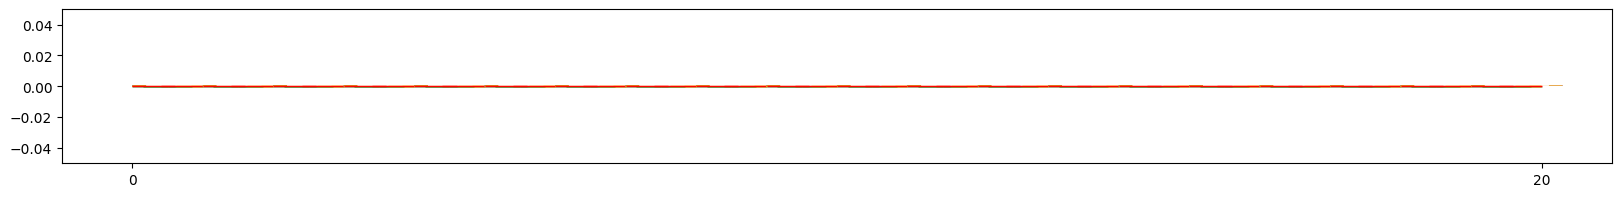

In [16]:
# print(gradients)
# print(data_one_hot)

viz_sequence.plot_weights(data_one_hot[0][:20], subticks_frequency=20)

# motif_utilities.plot_weights(data_one_hot[0][:20])